In [2]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import callbacks
from keras import optimizers
from string import punctuation
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional

In [3]:
!git clone https://github.com/Jayagn/Fake-news-challenge.git

fatal: destination path 'Fake-news-challenge' already exists and is not an empty directory.


In [ ]:
cd Fake-news-challenge/

In [120]:
#Specifying the folder locations
GloVe_DIR = './data/glove.twitter.27B.50d.txt'
DATA_DIR = './data'
MAX_SENT_LEN = 150 #to be tested on (150, 300 and 700)
MAX_VOCAB_SIZE = 28000 #vocabulary
BATCH_SIZE = 512
N_EPOCHS = 20 
LSTM_DIM = 50
EMBEDDING_DIM = 50 

In [121]:
seed = 1
np.random.seed(seed)

In [122]:
# Read the text files of fnc data
bodies = pd.read_csv(DATA_DIR + '/body_id.csv')
train_df = pd.read_csv(DATA_DIR + '/train.csv')
#validation_df = pd.read_csv(DATA_DIR + '/validation_data.csv')
test_df = pd.read_csv(DATA_DIR + '/test.csv')

In [123]:
train_df.replace('unrelated',1,True)
train_df.replace('agree',2,True)
train_df.replace('disagree',3,True)
train_df.replace('discuss',4,True)
combine_df_train = train_df.join(bodies.set_index('Body ID'), on='Body ID')
combine_df_test = test_df.join(bodies.set_index('Body ID'), on='Body ID')

In [125]:
#Pre-processing the data
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]
word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [126]:
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])
for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])

In [ ]:
#Tokenizing sentences
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])

In [128]:
#Combining headline and body together
word_seq_train = [list(i) for i in word_seq_head_train]
for i in range(len(word_seq_head_train)):
    word_seq_train[i].extend(word_seq_bodies_train[i]) 
    
word_seq_test = [list(i) for i in word_seq_head_test]
for i in range(len(word_seq_head_test)):
    word_seq_test[i].extend(word_seq_bodies_test[i])

In [129]:
#Padding the data
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = combine_df_train['Stance']

In [130]:
#Converting the sequence of words to sequnce of indices
X_test = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test])
X_test = pad_sequences(X_test, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

In [131]:
#One hot encoding
encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [132]:
X_train, X_vali, y_train, y_vali = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)

In [133]:
#GloVes embedding
glove_input_file = GloVe_DIR
word2vec_output_file = 'glove.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [134]:
#Create an embedding matrix containing only the word's in our vocabulary
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items(): 
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None

    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

# Bidirectional LSTM

In [135]:
#Building Bidirectional LSTM Model
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=EMBEDDING_DIM, weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', 
                      mask_zero=True))
#mask_zero is to deal with padding problem
model_1.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model_1.add(Dropout(rate=0.8, name='dropout_1')) #tried varying dropout rates
model_1.add(Dense(4, activation='softmax', name='output_layer'))

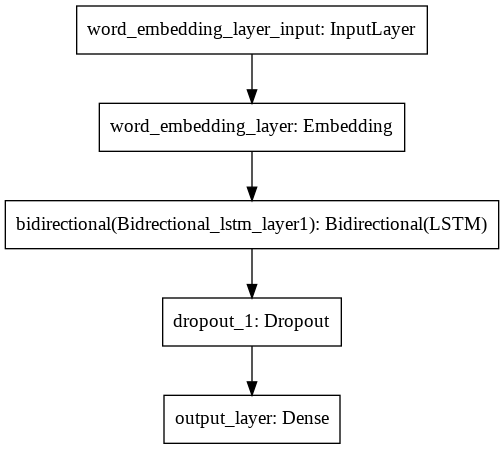

In [24]:
plot_model(model_1, to_file='bidirectional_lstm.png')

In [136]:
model_1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1686400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 404       
Total params: 1,727,204
Trainable params: 1,727,204
Non-trainable params: 0
_________________________________________________________________


In [137]:
#use adam optimizer
model_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=20, validation_data=(X_vali, y_vali))

Epoch 1/20
71/71 [==============================] - 86s 1s/step - loss: 0.9533 - accuracy: 0.6781 - val_loss: 0.7875 - val_accuracy: 0.7299
Epoch 2/20
71/71 [==============================] - 84s 1s/step - loss: 0.8150 - accuracy: 0.7336 - val_loss: 0.7554 - val_accuracy: 0.7299
Epoch 3/20
71/71 [==============================] - 84s 1s/step - loss: 0.7627 - accuracy: 0.7393 - val_loss: 0.7070 - val_accuracy: 0.7435
Epoch 4/20
71/71 [==============================] - 84s 1s/step - loss: 0.6889 - accuracy: 0.7583 - val_loss: 0.6315 - val_accuracy: 0.7703
Epoch 5/20
71/71 [==============================] - 84s 1s/step - loss: 0.6125 - accuracy: 0.7857 - val_loss: 0.5698 - val_accuracy: 0.7938
Epoch 6/20
71/71 [==============================] - 84s 1s/step - loss: 0.5609 - accuracy: 0.8044 - val_loss: 0.5452 - val_accuracy: 0.7998
Epoch 7/20
71/71 [==============================] - 85s 1s/step - loss: 0.5222 - accuracy: 0.8189 - val_loss: 0.5052 - val_accuracy: 0.8183
Epoch 8/20
71/71 [==

In [ ]:
model_1.save('bidirectional_lstm_150.h5')

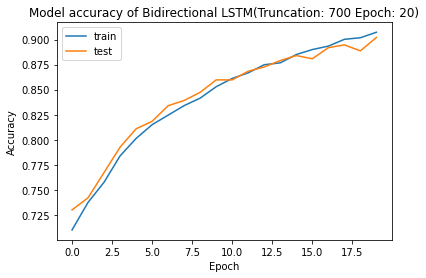

In [69]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy of Bidirectional LSTM(Truncation: 700 Epoch: 20)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
history_1_df = pd.DataFrame(history_1.history)

In [71]:
history_1_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.885999,0.709899,0.774480,0.729864
1,0.778361,0.737409,0.717793,0.742007
2,0.706355,0.757538,0.639241,0.767286
3,0.623249,0.783836,0.569476,0.792565
4,0.559984,0.801267,0.525170,0.810905


In [72]:
history_1_df.to_csv("history_1_700.csv",header=True,index=False)

In [87]:
#Only LSTM
#Build a sequential model by stacking neural net units
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model_2.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer'))
model_2.add(Activation(activation='relu', name='activation_1'))
model_2.add(Dense(4, activation='softmax', name='output_layer'))
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1686400   
_________________________________________________________________
lstm_layer (LSTM)            (None, 50)                20200     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 204       
Total params: 1,706,804
Trainable params: 20,404
Non-trainable params: 1,686,400
_________________________________________________________________


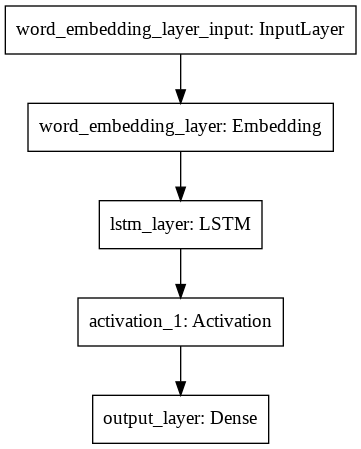

In [88]:
plot_model(model_2, to_file='lstm.png')

In [89]:
optimizer = optimizers.Adam(lr=0.001)
model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [90]:
history_2 = model_2.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=20,
          validation_data=(X_vali, y_vali)
         )
model_2.save('lstm_700.h5')

Epoch 1/20
71/71 [==============================] - 188s 3s/step - loss: 0.8476 - accuracy: 0.7318 - val_loss: 0.7927 - val_accuracy: 0.7299
Epoch 2/20
71/71 [==============================] - 179s 3s/step - loss: 0.7731 - accuracy: 0.7353 - val_loss: 0.7788 - val_accuracy: 0.7299
Epoch 3/20
71/71 [==============================] - 178s 3s/step - loss: 0.7602 - accuracy: 0.7353 - val_loss: 0.7699 - val_accuracy: 0.7299
Epoch 4/20
71/71 [==============================] - 179s 3s/step - loss: 0.7484 - accuracy: 0.7353 - val_loss: 0.7566 - val_accuracy: 0.7301
Epoch 5/20
71/71 [==============================] - 179s 3s/step - loss: 0.7344 - accuracy: 0.7358 - val_loss: 0.7397 - val_accuracy: 0.7299
Epoch 6/20
71/71 [==============================] - 178s 3s/step - loss: 0.7181 - accuracy: 0.7389 - val_loss: 0.7413 - val_accuracy: 0.7314
Epoch 7/20
71/71 [==============================] - 179s 3s/step - loss: 0.6997 - accuracy: 0.7447 - val_loss: 0.7125 - val_accuracy: 0.7405
Epoch 8/20
71

In [40]:
model_2.save('lstm_700.h5')

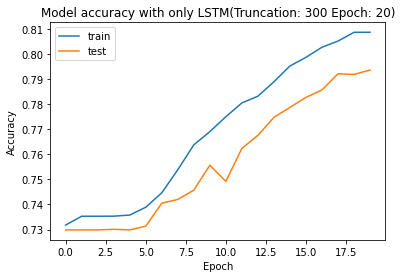

In [91]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy with only LSTM(Truncation: 300 Epoch: 20)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
history_2_df = pd.DataFrame(history_2.history)
history_2_df.to_csv("history_2_700.csv",header=True,index=False)

In [108]:
#LSTM Model with BatchNormalization and Dropouts
#Build a sequential model by stacking neural net units 
#dense layer: simply a layer connect units 
#dropout layer: for reduce overfitting a regularization method
model_3 = Sequential()
model_3.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=EMBEDDING_DIM, weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model_3.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer')) # Can try Bidirectional-LSTM

#model.add(Dense(32, name='dense_1'))
model_3.add(BatchNormalization(name='bn_1')) # BN did not really help with performance 
model_3.add(Dropout(rate=0.4, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
model_3.add(Activation(activation='relu', name='activation_1'))


#model.add(Dense(8, name='dense_2'))
model_3.add(BatchNormalization(name='bn_2'))
model_3.add(Dropout(rate=0.2, name='dropout_2'))
#model_3.add(Activation(activation='relu', name='activation_2'))

model_3.add(Dense(4, activation='softmax', name='output_layer'))
model_3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1686400   
_________________________________________________________________
lstm_layer (LSTM)            (None, 50)                20200     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)              

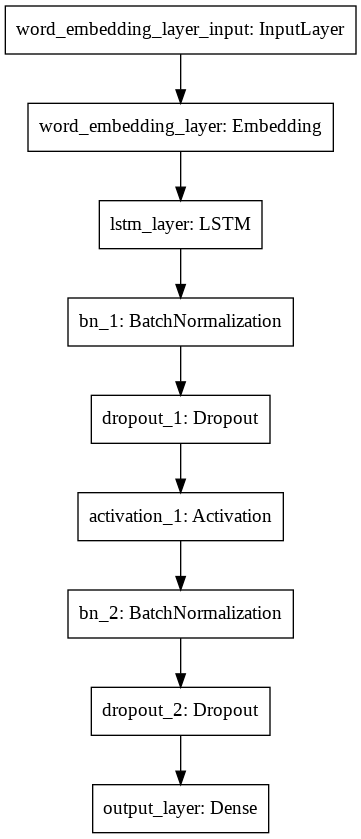

In [109]:
plot_model(model_3, to_file='lstm_with_dropout.png')

In [110]:
optimizer = optimizers.Adam(lr=0.001)
model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [111]:
history_3 = model_3.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=20,
          validation_data=(X_vali, y_vali)
         )
model_3.save('lstm_with_dropout_700.h5')

Epoch 1/20
71/71 [==============================] - 173s 2s/step - loss: 1.5770 - accuracy: 0.3204 - val_loss: 1.1733 - val_accuracy: 0.7301
Epoch 2/20
71/71 [==============================] - 171s 2s/step - loss: 1.1478 - accuracy: 0.5411 - val_loss: 0.9868 - val_accuracy: 0.7299
Epoch 3/20
71/71 [==============================] - 170s 2s/step - loss: 0.9237 - accuracy: 0.6781 - val_loss: 0.8620 - val_accuracy: 0.7299
Epoch 4/20
71/71 [==============================] - 170s 2s/step - loss: 0.8122 - accuracy: 0.7226 - val_loss: 0.7772 - val_accuracy: 0.7299
Epoch 5/20
71/71 [==============================] - 171s 2s/step - loss: 0.7705 - accuracy: 0.7333 - val_loss: 0.7531 - val_accuracy: 0.7323
Epoch 6/20
71/71 [==============================] - 171s 2s/step - loss: 0.7405 - accuracy: 0.7399 - val_loss: 0.7258 - val_accuracy: 0.7316
Epoch 7/20
71/71 [==============================] - 173s 2s/step - loss: 0.7216 - accuracy: 0.7446 - val_loss: 0.7068 - val_accuracy: 0.7323
Epoch 8/20
71

In [47]:
model_3.save('lstm_with_dropout.h5')

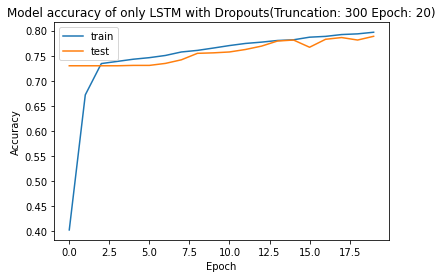

In [99]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy of only LSTM with Dropouts(Truncation: 300 Epoch: 20)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [112]:
history_3_df = pd.DataFrame(history_3.history)
history_3_df.to_csv("history_3_700.csv",header=True,index=False)

In [113]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [116]:
model_4 = Sequential()
model_4.add(Embedding(input_dim=len(tokenizer.word_index)+1, input_length = MAX_SENT_LEN,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable= False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model_4.add(LSTM(LSTM_DIM, return_sequences=True, name='lstm_layer')) # Can try Bidirectional-LSTM
model_4.add(Dropout(rate=0.2, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
model_4.add(Activation(activation='relu', name='activation_1'))
#output (batch_size, timesteps, input_dim)
model_4.add(attention())
model_4.add(Dense(4, activation='softmax', name='output_layer'))

In [117]:
model_4.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 700, 50)           1686400   
_________________________________________________________________
lstm_layer (LSTM)            (None, 700, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700, 50)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 700, 50)           0         
_________________________________________________________________
attention_1 (attention)      (None, 50)                750       
_________________________________________________________________
output_layer (Dense)         (None, 4)                 204       
Total params: 1,707,554
Trainable params: 21,154
Non-trainable params: 1,686,400
______________________________________

In [118]:
optimizer = optimizers.Adam(lr=0.001) # Try a different learning rate

model_4.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [119]:
history_4 = model_4.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=20,
          validation_data=(X_vali, y_vali)
         )
model_4.save('lstm_with_attention_700.h5')

Epoch 1/20
71/71 [==============================] - 198s 3s/step - loss: 0.9084 - accuracy: 0.6916 - val_loss: 0.8012 - val_accuracy: 0.7299
Epoch 2/20
71/71 [==============================] - 197s 3s/step - loss: 0.7829 - accuracy: 0.7353 - val_loss: 0.7861 - val_accuracy: 0.7299
Epoch 3/20
71/71 [==============================] - 198s 3s/step - loss: 0.7676 - accuracy: 0.7355 - val_loss: 0.7731 - val_accuracy: 0.7306
Epoch 4/20
71/71 [==============================] - 198s 3s/step - loss: 0.7554 - accuracy: 0.7355 - val_loss: 0.7612 - val_accuracy: 0.7306
Epoch 5/20
71/71 [==============================] - 198s 3s/step - loss: 0.7434 - accuracy: 0.7363 - val_loss: 0.7571 - val_accuracy: 0.7326
Epoch 6/20
71/71 [==============================] - 199s 3s/step - loss: 0.7305 - accuracy: 0.7385 - val_loss: 0.7441 - val_accuracy: 0.7361
Epoch 7/20
71/71 [==============================] - 199s 3s/step - loss: 0.7423 - accuracy: 0.7376 - val_loss: 0.8017 - val_accuracy: 0.7323
Epoch 8/20
71